In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [2]:
full_train_data = pd.read_csv('train.csv')
full_test_data = pd.read_csv("test.csv")

We start separating the full_train_data into a training and a test set, so we can evaluate the performance before the final prediction over the full_test_data.

In [22]:
X = full_train_data.drop(['Survived'], axis=1)
y = full_train_data['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

Inspecting the data to see the features it has.

In [90]:
df.head(2)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
685,686,2,"Laroche, Mr. Joseph Philippe Lemercier",male,25.0,1,2,SC/Paris 2123,41.5792,NaN,C
614,615,3,"Brocklebank, Mr. William Alfred",male,35.0,0,0,364512,8.0500,NaN,S


Data Dictionary from Kaggle
Variable	Definition	                      Key

survival	Survival	                      0 = No, 1 = Yes
pclass	    Ticket class                  	  1 = 1st, 2 = 2nd, 3 = 3rd
sex	        Sex	
Age	        Age in years	
sibsp	    # of siblings / spouses aboard the Titanic	
parch	    # of parents / children aboard the Titanic	
ticket	    Ticket number	
fare	    Passenger fare	
cabin	    Cabin number	
embarked	Port of Embarkation	               C = Cherbourg, Q = Queenstown, S = Southampton

Variable Notes

pclass: A proxy for socio-economic status (SES) 
1st = Upper
2nd = Middle
3rd = Lower

age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5

sibsp: The dataset defines family relations in this way...
Sibling = brother, sister, stepbrother, stepsister
Spouse = husband, wife (mistresses and fiancés were ignored)

parch: The dataset defines family relations in this way...
Parent = mother, father
Child = daughter, son, stepdaughter, stepson
Some children travelled only with a nanny, therefore parch=0 for them.

The goal is to use the dataset above to train a model that predicts if a passenger survived or not. One has to clearly use supervided learning since the predicted feature is given to train the model with the train dataset.

The pandas method info() allows us to identify many characteristics of the data: # of points (rows), # of features (columns), data type of each feature (numeric or textual), how many missing values there are for each feature (which must be handled), and the name of all the features along with its associated column.  

There are some features that should not influence the survival change, like PassengerId, Name, Ticket, and Cabin. So we remove those features from the data set from the beginning. I am leaving PassangerId because it is used to submit the predictions.

In [32]:
def drop_columns(df):
    '''
    Removes the features 'Name', 'Cabin', and 'Ticket'
    from the titanic data.
    '''
    if 'Name' in df:
        df.drop(['Name', 'Cabin', 'Ticket'], axis=1)
    else:
        pass
    return df

The features we are going to use are set. We separate the categorical features from the numerical features so we are able to stramline them with different transformers in the pipeline.

In [6]:
cat_cols = ['Sex','Embarked']
num_cols = ['PassengerId', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

Let us now deal with missing data. There are two features missing data, one numerical and one categorical.

We now create a Pipeline to impute the missing values and to encode the categorical features as numerical features.

In [8]:
pipe_cat = Pipeline([
    ('impute_cat', SimpleImputer(strategy='most_frequent')),
    ('encode_cat', OrdinalEncoder())
])
pipe_num = Pipeline([
    ('impute_num',SimpleImputer(strategy='mean'))
])
pipe_normalize = Pipeline([
    ('normalize',StandardScaler())
])

In [9]:
ct = ColumnTransformer([
    ('pipe_cat', pipe_cat, cat_cols),
    ('pipe_num', pipe_num, num_cols)
])

norm = ColumnTransformer([
    ('normalize', pipe_normalize, ['Age', 'Fare'])],
    remainder='passthrough')

Pipeline everything

In [33]:
def prepare_for_estimator(df):  
    aux = pd.DataFrame(ct.fit_transform(drop_columns(df)), columns=cat_cols+num_cols)
    return norm.fit_transform(aux)

In [34]:
X_train = prepare_for_estimator(X_train)
X_test = prepare_for_estimator(X_test)

# Random Forest Classifier

In [212]:
random_forest = RandomForestClassifier(n_estimators=200)
random_forest.fit(X_train,y_train)
pred_random_forest = random_forest.predict(X_test)

In [213]:
print(classification_report(y_test,pred_random_forest))
print(confusion_matrix(y_test,pred_random_forest))

              precision    recall  f1-score   support

           0       0.84      0.86      0.85       114
           1       0.75      0.72      0.73        65

    accuracy                           0.81       179
   macro avg       0.80      0.79      0.79       179
weighted avg       0.81      0.81      0.81       179

[[98 16]
 [18 47]]


In [214]:
support_vector = SVC()
support_vector.fit(X_train,y_train)
pred_support_vector = support_vector.predict(X_test)

In [215]:
print(classification_report(y_test,pred_support_vector))
print(confusion_matrix(y_test,pred_support_vector))

              precision    recall  f1-score   support

           0       0.64      1.00      0.78       114
           1       0.00      0.00      0.00        65

    accuracy                           0.64       179
   macro avg       0.32      0.50      0.39       179
weighted avg       0.41      0.64      0.50       179

[[114   0]
 [ 65   0]]


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [216]:
score_random_forest = accuracy_score(y_test,pred_random_forest)
score_support_vector = accuracy_score(y_test,pred_support_vector)

In [217]:
print(score_random_forest)
print(score_support_vector)

0.8100558659217877
0.6368715083798883


The random forest classifier did better, so I'm going to train the model on the whole training set with it.

In [49]:
X_train = full_train_data.drop(columns='Survived', axis=1)
y_train = full_train_data['Survived']

In [50]:
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)

RandomForestClassifier(n_estimators=200)

In [73]:
test_data = pd.read_csv('test.csv')

Modify the test data accordingly (this is where I need to lear how to use pipelines)

In [74]:
test_data.drop(columns=['Name','Ticket','Cabin'], inplace=True)
test_data['Sex'] = test_data['Sex'].apply(lambda x: 1 if x=='female' else -1)
test_data['Embarked'] = test_data['Embarked'].apply(lambda x: 1 if x=='C' else 0 if x=='Q' else -1)
test_data.fillna(test_data['Age'].mean(), inplace=True)

In [75]:
prediction_rfc = rfc.predict(test_data)

In [76]:
final_prediction = test_data.copy()

In [77]:
final_prediction['Survived'] = prediction_rfc

In [78]:
final_prediction.drop(columns=['Pclass','Sex','Age','SibSp','Parch','Fare','Embarked'], inplace=True)

In [79]:
final_prediction

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [80]:
final_prediction.to_csv('final_prediction.csv', index=False)

Now I need to scale the data.

Select columns and rows. loc uses the labels for the rows and iloc uses the integer position.

In [79]:
#full_train_data.loc[full_train_data['Age'] == 23]
#full_train_data[['Fare','Age']]
#full_train_data.iloc[[0,1]]
#full_train_data.iloc[[0,1],[0,5]]
#full_train_data.loc[[0,1],['Age','Sex']]
#full_train_data.loc[3:10,'Sex':'Fare']

We can also filter with lists using isin()

In [80]:
#cities = ['S','C']
#filter_cities = full_train_data['Embarked'].isin(cities)
#full_train_data[filter_cities]

Modify all columns (feature names)

In [14]:
#test = full_train_data.copy()
#test.columns = [x.upper() for x in test.columns]
#test.columns = test.columns.str.replace('S','s')

Modify a few columns (with a dictionary)

In [9]:
#test.rename(columns={'EMBARKED':'City','AGE':'Idade'}, inplace=True)
#test

Modify entries (data). Pick the row or cell you want to edit and assign it the different value

In [10]:
#test.loc[0,['Idade','City']] = ['não',1]
#test

Operation on the whole column

In [11]:
#test['City'] = test['City'].str.lower()
#test

Apply is used to apply a function on our values. It works on dataframes or series objects

In [18]:
#series
test['NAME'].apply(len)
test['NAME'].apply(lambda x: x.upper())
#dataframe
test.apply(len) #test.apply(len, axis='rows') applies to each row
#test.apply(len, axis='columns') #applies to each column not entry

PAssENGERID    891
sURVIVED       891
PCLAss         891
NAME           891
sEX            891
Idade          891
sIBsP          891
PARCH          891
TICKET         891
FARE           891
CABIN          891
City           891
dtype: int64

In [19]:
Applymap applies the function to all entries of a dataframe

SyntaxError: invalid syntax (<ipython-input-19-298ef25ba899>, line 1)

In [ ]:
full_train_data[['Name','Embarked']].applymap(lambda x: x.upper(), na_action='ignore')

Map is used to substitute the values on a Series by other values. Everything not changed is replaced by NaN. To keep what we had we use Replace method

In [ ]:
test['EMBARKED'].map({'c': 'C','a': 'SEC'})
test['EMBARKED'].replace({'c': 'C','a': 'SEC'})

Add remove or combine rows and columns

Add features

In [66]:
aux = full_train_data.copy()
aux2 = full_train_data.copy()
aux3 = full_train_data.copy()

In [65]:
aux['Age'] + aux['Pclass'] +1 +aux['Age']*10
aux['Name'] + ' ' + aux['Embarked']
aux['new feature'] = aux['Name'] + ' ' + aux['Embarked']

Split

In [55]:
aux['new feature'].str.split(' ', expand=True)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,"Braund,",Mr.,Owen,Harris,S,None,None,None,None,None,None,None,None,None,None
1,"Cumings,",Mrs.,John,Bradley,(Florence,Briggs,Thayer),C,None,None,None,None,None,None,None
2,"Heikkinen,",Miss.,Laina,S,None,None,None,None,None,None,None,None,None,None,None
3,"Futrelle,",Mrs.,Jacques,Heath,(Lily,May,Peel),S,None,None,None,None,None,None,None
4,"Allen,",Mr.,William,Henry,S,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,"Montvila,",Rev.,Juozas,S,None,None,None,None,None,None,None,None,None,None,None
887,"Graham,",Miss.,Margaret,Edith,S,None,None,None,None,None,None,None,None,None,None
888,"Johnston,",Miss.,Catherine,Helen,"""Carrie""",S,None,None,None,None,None,None,None,None,None
889,"Behr,",Mr.,Karl,Howell,C,None,None,None,None,None,None,None,None,None,None


Add row, can append another dataframe as well

In [70]:
aux3.append({'Age': 1000}, ignore_index=True)
aux3 = aux3.append({'Age': 1000}, ignore_index=True)
#dataframe1.append(dataframe2, ignore_index=True)

Drop rows (can also use conditionals to drop)

In [74]:
aux3.tail()
aux3.drop(index=891)
#aux3.drop(index=conditional.index)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1.0,0.0,3.0,"Braund, Mr. Owen Harris",male,22.0,1.0,0.0,A/5 21171,7.2500,NaN,S
1,2.0,1.0,1.0,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1.0,0.0,PC 17599,71.2833,C85,C
2,3.0,1.0,3.0,"Heikkinen, Miss. Laina",female,26.0,0.0,0.0,STON/O2. 3101282,7.9250,NaN,S
3,4.0,1.0,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S
4,5.0,0.0,3.0,"Allen, Mr. William Henry",male,35.0,0.0,0.0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887.0,0.0,2.0,"Montvila, Rev. Juozas",male,27.0,0.0,0.0,211536,13.0000,NaN,S
887,888.0,1.0,1.0,"Graham, Miss. Margaret Edith",female,19.0,0.0,0.0,112053,30.0000,B42,S
888,889.0,0.0,3.0,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1.0,2.0,W./C. 6607,23.4500,NaN,S
889,890.0,1.0,1.0,"Behr, Mr. Karl Howell",male,26.0,0.0,0.0,111369,30.0000,C148,C


In [75]:
aux4 = full_train_data.copy()

Sorting rows within columns

In [86]:
aux4['Name'].sort_values()
aux4.sort_values(by='Age', ascending=False)
aux4.sort_values(by=['Age','Name'])
aux4.sort_values(by=['Age','Name'], ascending=[False,True], inplace=True)
#aux4.sort_index() to sort the indices back

In [87]:
aux5 = full_train_data.copy()

Sorting largest minimum values

In [96]:
aux5['Age'].nlargest(10)
aux5.nlargest(20, 'Age')
aux5.nsmallest(20, 'Age')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
803,804,1,3,"Thomas, Master. Assad Alexander",male,0.42,0,1,2625,8.5167,NaN,C
755,756,1,2,"Hamalainen, Master. Viljo",male,0.67,1,1,250649,14.5000,NaN,S
469,470,1,3,"Baclini, Miss. Helene Barbara",female,0.75,2,1,2666,19.2583,NaN,C
644,645,1,3,"Baclini, Miss. Eugenie",female,0.75,2,1,2666,19.2583,NaN,C
78,79,1,2,"Caldwell, Master. Alden Gates",male,0.83,0,2,248738,29.0000,NaN,S
831,832,1,2,"Richards, Master. George Sibley",male,0.83,1,1,29106,18.7500,NaN,S
305,306,1,1,"Allison, Master. Hudson Trevor",male,0.92,1,2,113781,151.5500,C22 C26,S
164,165,0,3,"Panula, Master. Eino Viljami",male,1.00,4,1,3101295,39.6875,NaN,S
172,173,1,3,"Johnson, Miss. Eleanor Ileen",female,1.00,1,1,347742,11.1333,NaN,S
183,184,1,2,"Becker, Master. Richard F",male,1.00,2,1,230136,39.0000,F4,S


In [98]:
aux5['Age'].median()

28.0

In [99]:
aux5['Age'].count()

714

In [102]:
aux4['Age'].value_counts()

24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
12.00     1
74.00     1
0.92      1
34.50     1
80.00     1
Name: Age, Length: 88, dtype: int64

In [106]:
aux5['Sex'].value_counts(normalize=True)

male      0.647587
female    0.352413
Name: Sex, dtype: float64

Group data

In [108]:
class_group = aux5.groupby('Pclass')

In [110]:
class_group.get_group(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.0,0,0,113783,26.5500,C103,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.0,0,0,113788,35.5000,A6,S
...,...,...,...,...,...,...,...,...,...,...,...,...
871,872,1,1,"Beckwith, Mrs. Richard Leonard (Sallie Monypeny)",female,47.0,1,1,11751,52.5542,D35,S
872,873,0,1,"Carlsson, Mr. Frans Olof",male,33.0,0,0,695,5.0000,B51 B53 B55,S
879,880,1,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S


In [111]:
class_group['Sex'].value_counts() #multiple index

Pclass  Sex   
1       male      122
        female     94
2       male      108
        female     76
3       male      347
        female    144
Name: Sex, dtype: int64

In [114]:
class_group['Age'].agg(['median','mean'])

,median,mean
Pclass,,
1,37.0,38.233441
2,29.0,29.877630
3,24.0,25.140620


In [116]:
class_group['Age'].apply(lambda x: x*10)

0      220.0
1      380.0
2      260.0
3      350.0
4      350.0
       ...  
886    270.0
887    190.0
888      NaN
889    260.0
890    320.0
Name: Age, Length: 891, dtype: float64

Dropping missing values

In [121]:
aux5.dropna(axis='index', how='any', subset=['Age'])

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Replaces nan values with something

In [122]:
aux5.fillna('MISSING')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,MISSING,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,MISSING,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,MISSING,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,MISSING,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,MISSING,1,2,W./C. 6607,23.4500,MISSING,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Converts the type of a column (or dataframe) to something else (like string to float). Nan is a float type

In [126]:
aux5['Age'].astype(str) #transformed the ages in strings

0      22.0
1      38.0
2      26.0
3      35.0
4      35.0
       ... 
886    27.0
887    19.0
888     nan
889    26.0
890    32.0
Name: Age, Length: 891, dtype: object

In [128]:
aux5['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

Does not cut (truncate) columns or rows.

In [ ]:
pd.set_option('display.max_columns', 85) 
pd.set_option('display.max_rows', 85)

I will plot the correlation matrix for all the current numerical data.

In [81]:
full_train_data.corr()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
Survived,1.000000,-0.359653,0.538826,-0.077221,-0.017358,0.093317,0.268189,0.179775
Pclass,-0.359653,1.000000,-0.155460,-0.369226,0.067247,0.025683,-0.554182,-0.241154
Sex,0.538826,-0.155460,1.000000,-0.093254,0.103950,0.246972,0.184994,0.107411
Age,-0.077221,-0.369226,-0.093254,1.000000,-0.308247,-0.189119,0.096067,0.030394
SibSp,-0.017358,0.067247,0.103950,-0.308247,1.000000,0.383820,0.138329,-0.032234
Parch,0.093317,0.025683,0.246972,-0.189119,0.383820,1.000000,0.205119,-0.011057
Fare,0.268189,-0.554182,0.184994,0.096067,0.138329,0.205119,1.000000,0.281863
Embarked,0.179775,-0.241154,0.107411,0.030394,-0.032234,-0.011057,0.281863,1.000000


I copied from this video this code https://www.youtube.com/watch?v=fATVVQfFyU0

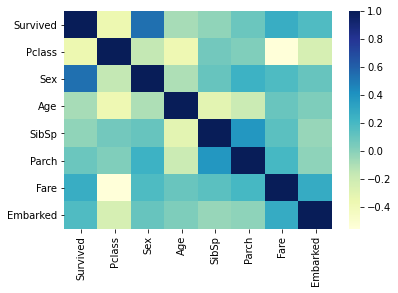

<AxesSubplot:xlabel='Survived', ylabel='count'>

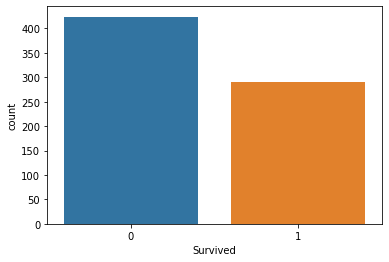

In [82]:
import seaborn as sns
sns.heatmap(full_train_data.corr(),cmap='YlGnBu')
plt.show()
sns.countplot(x=full_train_data['Survived'])

We can notice that the Pclass and Fare features are the most correlated with the target feature Survived. For simplicity, I will only consider these feature for the moment to train the model.

In [ ]:
reduced_train_data = full_train_data[['Pclass','Fare','Survived']]
reduced_train_data

In [ ]:
reduced_train_data['Fare'].plot()

In [ ]:
reduced_train_data.plot.scatter(x="Fare", y="Survived", alpha=0.5)

In [ ]:
X = reduced_train_data[['Pclass','Fare']]
y = reduced_train_data['Survived']

In [ ]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

NameError: name 'X_train' is not defined

# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)
prediction_rfc = rfc.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
print(classification_report(y_test,prediction_rfc))
print(confusion_matrix(y_test,prediction_rfc))

# SVM (support vector model) classifier

In [ ]:
from sklearn.svm import SVC
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train,y_train)
prediction_clf = clf.predict(X_test)

In [ ]:
print(classification_report(y_test,prediction_clf))
print(confusion_matrix(y_test,prediction_clf))

In [ ]:
from sklearn.metrics import accuracy_score
score_rfc = accuracy_score(y_test,prediction_rfc)
score_clf = accuracy_score(y_test,prediction_clf)

In [ ]:
print(score_rfc)
print(score_clf)